In [1]:
# Basket name: Patents+OCHEM+Enamine+Bradley+Begström (training)
# This basket belongs to user: published, created by dan2097

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from rdkit.Chem import AllChem, MolFromSmiles, Descriptors
import pandas as pd
from tqdm import tqdm
from tqdm.contrib import tzip
import random
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import Pool

random.seed(42)

/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
HOME = "/home/ec2-user/np-clinical-trials"

In [3]:
coconut_smiles_list = (
    pd.read_csv(f"{HOME}/data/COCONUT_DB.smi", delim_whitespace=True, header=None)[0]
    .unique()
    .tolist()
)
coconut_smiles_list = random.sample(coconut_smiles_list, 1000)

In [4]:
OCHEM_subset_smiles_list = (
    pd.read_csv(f"{HOME}/data/DDS-50.smi", delim_whitespace=True, header=None)[0]
    .unique()
    .tolist()
)
OCHEM_subset_smiles_list = random.sample(OCHEM_subset_smiles_list, 1000)

In [5]:
synthetic_smiles_list = (
    pd.read_csv(f"{HOME}/data/OCHEM_data.csv", sep=";")["SMILES"].unique().tolist()
)
synthetic_smiles_list = random.sample(synthetic_smiles_list, 1000)

/tmp/ipykernel_95086/2798491370.py:2: DtypeWarning: Columns (6,13,14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv(f"{HOME}/data/OCHEM_data.csv", sep=";")["SMILES"].unique().tolist()


In [6]:
results_dictionary = {
    "OCHEM": {"SMILES": OCHEM_subset_smiles_list},
    "Coconut": {"SMILES": coconut_smiles_list},
    "Synthetic": {"SMILES": synthetic_smiles_list},
}


def conversion_with_rdkit(input_smiles):
    try:
        return MolFromSmiles(input_smiles)
    except:
        return None


fpgen = AllChem.GetRDKitFPGenerator()
for current_subset in results_dictionary:
    molecules_list = []
    with Pool(16) as p:
        molecules_list = list(
            tqdm(
                p.imap(
                    conversion_with_rdkit, results_dictionary[current_subset]["SMILES"]
                ),
                total=len(results_dictionary[current_subset]["SMILES"]),
            )
        )

    results_dictionary[current_subset]["Molecules"] = molecules_list

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 6623.43it/s]


In [7]:
fpgen = AllChem.GetRDKitFPGenerator()

In [8]:
def calculate_fingerprints(input_molecule):
    try:
        return Descriptors.CalcMolDescriptors(input_molecule)
    except:
        return None


for current_subset in results_dictionary:
    fps_list, valid_smiles = [], []
    with Pool(16) as p:
        fps_list = list(
            tqdm(
                p.imap(
                    calculate_fingerprints,
                    results_dictionary[current_subset]["Molecules"],
                ),
                total=len(results_dictionary[current_subset]["Molecules"]),
            )
        )
    valid_smiles = []
    for current_smiles, current_fingerprint in tzip(
        results_dictionary[current_subset]["SMILES"], fps_list
    ):
        if current_fingerprint is not None:
            valid_smiles.append(current_smiles)
        else:
            valid_smiles.append(None)

    fps_df = pd.DataFrame(fps_list)
    fps_df["SMILES"] = valid_smiles
    fps_df["source"] = current_subset
    results_dictionary[current_subset]["features"] = fps_df

  9%|▊         | 87/1000 [00:00<00:01, 855.14it/s]

100%|██████████| 1000/1000 [00:00<00:00, 874542.12it/s]


In [9]:
full_fingerprints_df = pd.concat(
    [
        results_dictionary["OCHEM"]["features"],
        results_dictionary["Coconut"]["features"],
        results_dictionary["Synthetic"]["features"],
    ]
)

In [10]:
full_fingerprints_df.to_csv(f"{HOME}/data/full_fingerprints_df.csv", index=False)

In [11]:
ids_columns = full_fingerprints_df[["source", "SMILES"]]
features_df = full_fingerprints_df.drop(columns=["SMILES", "source"])

In [12]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df.fillna(0))
scaled_features = pd.DataFrame(
    scaled_features, columns=features_df.columns, index=ids_columns.index
)

In [13]:
PCA_object = PCA(n_components=2)
PCA_features = PCA_object.fit_transform(scaled_features)

/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

Text(0, 0.5, 'PC2')

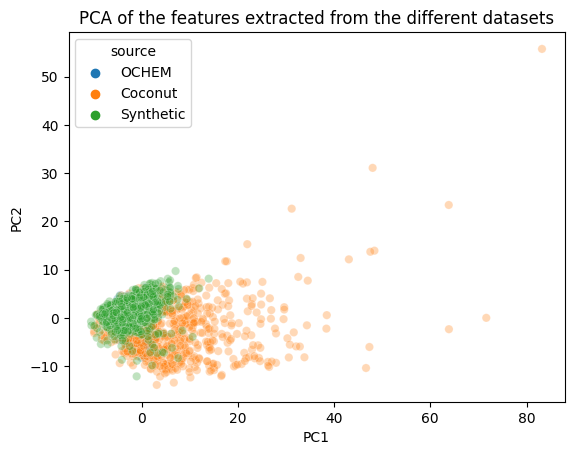

In [14]:
sns.scatterplot(
    x=PCA_features[:, 0],
    y=PCA_features[:, 1],
    hue=ids_columns["source"],
    alpha=0.3,
)
plt.title("PCA of the features extracted from the different datasets")
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.savefig("PCA_plot.png")

In [29]:
Z = linkage(
    scaled_features, method="ward"
)  # Perform hierarchical/agglomerative clustering

In [ ]:
clusters = fcluster(Z, t=30, criterion="maxclust")

In [30]:
cluster_colors = {
    1: "red",
    2: "green",
    3: "blue",
    4: "yellow",
    5: "purple",
    6: "orange",
    7: "pink",
    8: "brown",
    9: "black",
    0: "grey",
    10: "cyan",
    11: "magenta",
    12: "gold",
    13: "silver",
    14: "olive",
    15: "maroon",
    16: "navy",
    17: "teal",
    18: "aqua",
    19: "lime",
    20: "fuchsia",
    21: "silver",
    22: "olive",
    23: "maroon",
    24: "navy",
    25: "teal",
    26: "aqua",
    27: "lime",
    28: "fuchsia",
    29: "silver",
    30: "olive",
}
origin_colors = {"OCHEM": "red", "Coconut": "blue", "Synthetic": "green"}

/tmp/ipykernel_95086/1782856017.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ids_columns["cluster"] = clusters
/home/ec2-user/np-clinical-trials/.venv/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


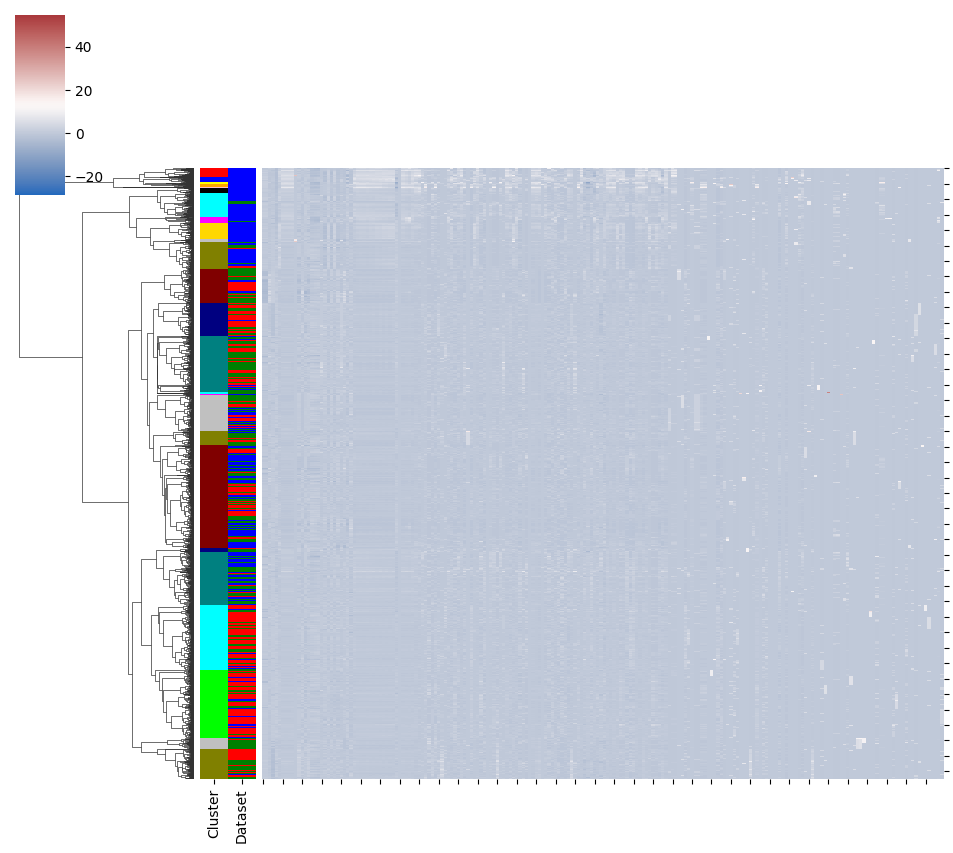

In [31]:
# kr-collapse
# Prepare row_colors for clusters
ids_columns["cluster"] = clusters

row_colors_clusters = ids_columns["cluster"].map(cluster_colors)
row_colors_origin = ids_columns["source"].map(origin_colors)

# Combine row_colors for both clusters and patients
row_colors_combined = pd.DataFrame(
    {
        "Cluster": row_colors_clusters,
        "Dataset": row_colors_origin,
    }
)

# Create the clustermap
ax = sns.clustermap(
    scaled_features,
    cmap="vlag",
    col_cluster=False,
    figsize=(10, 10),
    row_colors=row_colors_combined,
    method="ward",
    metric="euclidean",
)

ax.ax_heatmap.set_yticklabels([])
# hide x-axis labels
plt.setp(ax.ax_heatmap.get_xticklabels(), visible=False)

# Show the plot
plt.show()

In [32]:
"""
# Pick random sample from each cluster
for current_cluster in ids_columns["cluster"].unique():
    current_ids_subset = ids_columns.loc[ids_columns["cluster"] == current_cluster]
    current_features_subset = features_df.loc[current_ids_subset.index]
"""

'\n# Pick random sample from each cluster\nfor current_cluster in ids_columns["cluster"].unique():\n    current_ids_subset = ids_columns.loc[ids_columns["cluster"] == current_cluster]\n    current_features_subset = features_df.loc[current_ids_subset.index]\n'